Loading and setting up data


In [2]:
!pip install wordcloud plotly vaderSentiment textblob

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 4.0 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np

In [4]:
import nltk
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

nltk.download("stopwords")
nltk.download("wordnet")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [8]:
from google.colab import files
import pandas as pd

uploaded = files.upload()  # choose your CSV
df = pd.read_csv(next(iter(uploaded)))
print("Dataset shape:", df.shape)
print("Columns:", df.columns.tolist())
df.head()

Saving apple-event-2025.csv to apple-event-2025.csv
Dataset shape: (1067, 11)
Columns: ['text', 'start', 'duration', 'end', 'clean_text', 'tokens', 'word_count', 'sentiment', 'sentiment_num', 'entities', 'time_bin']


,text,start,duration,end,clean_text,tokens,word_count,sentiment,sentiment_num,entities,time_bin
0,♪ “Neon: 1. Shinjuku” by Hannah Peel \n& Manch...,0.163,3.771,3.934,♪ “neon: 1. shinjuku” by hannah peel \n& manch...,"['by', 'hannah', 'peel', 'manchester', 'collec...",5,NEGATIVE,-1,"[('1', 'CARDINAL'), ('hannah peel \n& manchest...",0.0
1,[HANDOFF TO HOMEPOD CONFIRMATION],11.942,1.635,13.577,[handoff to homepod confirmation],"['to', 'homepod']",2,NEGATIVE,-1,[],0.0
2,[CAMERA SHUTTER],14.411,1.001,15.412,[camera shutter],[],0,NEGATIVE,-1,[],0.0
3,[CHARGING CONFIRMATION],15.579,1.501,17.080,[charging confirmation],[],0,POSITIVE,1,[],0.0
4,[LOCATE REMOTE CHIME],18.615,1.969,20.584,[locate remote chime],['remote'],1,POSITIVE,1,[],0.0


Preparing labels and lexicon scores


In [9]:
# Keep only rows with non‑empty clean_text and valid sentiment label
df = df.dropna(subset=["clean_text", "sentiment"])
df = df[df["clean_text"].str.strip() != ""]

# Standardize text column name to `title` to reuse the old code structure
df["title"] = df["clean_text"].astype(str)

# Ensure sentiment is one of POSITIVE/NEGATIVE/NEUTRAL
df["sentiment"] = df["sentiment"].str.upper().replace({
    "POS": "POSITIVE",
    "NEG": "NEGATIVE"
})
df["sentiment"] = df["sentiment"].where(
    df["sentiment"].isin(["POSITIVE", "NEGATIVE", "NEUTRAL"]),
    "NEUTRAL"
)

df[["title", "sentiment"]].head()

,title,sentiment
0,♪ “neon: 1. shinjuku” by hannah peel \n& manch...,NEGATIVE
1,[handoff to homepod confirmation],NEGATIVE
2,[camera shutter],NEGATIVE
3,[charging confirmation],POSITIVE
4,[locate remote chime],POSITIVE


In [10]:
# Optional: compute lexicon scores for comparison, not for labeling
analyzer = SentimentIntensityAnalyzer()

def get_vader_score(text):
    if not isinstance(text, str) or not text.strip():
        return 0.0
    return analyzer.polarity_scores(text)["compound"]

def get_tb_score(text):
    if not isinstance(text, str) or not text.strip():
        return 0.0
    return TextBlob(text).sentiment.polarity

df["vader_score"] = df["title"].apply(get_vader_score)
df["tb_score"] = df["title"].apply(get_tb_score)
df["hybrid_score"] = df[["vader_score", "tb_score"]].mean(axis=1)

df[["title", "vader_score", "tb_score", "hybrid_score", "sentiment"]].head()

,title,vader_score,tb_score,hybrid_score,sentiment
0,♪ “neon: 1. shinjuku” by hannah peel \n& manch...,0.0,0.0,0.00,NEGATIVE
1,[handoff to homepod confirmation],0.0,0.0,0.00,NEGATIVE
2,[camera shutter],0.0,0.0,0.00,NEGATIVE
3,[charging confirmation],0.0,0.0,0.00,POSITIVE
4,[locate remote chime],0.0,-0.1,-0.05,POSITIVE


Train/test split and TF‑IDF models

In [11]:
X = df["title"].values
y = df["sentiment"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    stop_words="english"
)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [12]:
# Logistic Regression
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_tfidf, y_train)

y_pred_logreg = logreg.predict(X_test_tfidf)
print("Logistic Regression accuracy:", accuracy_score(y_test, y_pred_logreg))
print(classification_report(y_test, y_pred_logreg))

Logistic Regression accuracy: 0.7242990654205608
              precision    recall  f1-score   support

    NEGATIVE       0.50      0.03      0.06        59
    POSITIVE       0.73      0.99      0.84       155

    accuracy                           0.72       214
   macro avg       0.61      0.51      0.45       214
weighted avg       0.67      0.72      0.62       214



In [13]:
# Linear SVM
svm = LinearSVC()
svm.fit(X_train_tfidf, y_train)

y_pred_svm = svm.predict(X_test_tfidf)
print("Linear SVM accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))

Linear SVM accuracy: 0.7476635514018691
              precision    recall  f1-score   support

    NEGATIVE       0.61      0.24      0.34        59
    POSITIVE       0.76      0.94      0.84       155

    accuracy                           0.75       214
   macro avg       0.69      0.59      0.59       214
weighted avg       0.72      0.75      0.71       214



LSTM model


In [14]:
# Tokenize text
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(df["title"].values)

X_sequences = tokenizer.texts_to_sequences(df["title"].values)
max_len = 30  # Apple event segments are short; adjust if needed
X_padded = pad_sequences(X_sequences, maxlen=max_len, padding="post", truncating="post")

# Encode labels
label_to_idx = {label: idx for idx, label in enumerate(sorted(df["sentiment"].unique()))}
idx_to_label = {v: k for k, v in label_to_idx.items()}
y_int = df["sentiment"].map(label_to_idx).values
num_classes = len(label_to_idx)
y_cat = to_categorical(y_int, num_classes=num_classes)

X_train_pad, X_test_pad, y_train_cat, y_test_cat, y_train_int, y_test_int = train_test_split(
    X_padded, y_cat, y_int, test_size=0.2, random_state=42, stratify=y_int
)

In [15]:
vocab_size = min(10000, len(tokenizer.word_index) + 1)
embedding_dim = 64

lstm_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len),
    LSTM(64, return_sequences=False),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

lstm_model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

history = lstm_model.fit(
    X_train_pad,
    y_train_cat,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.7256 - loss: 0.6216 - val_accuracy: 0.6901 - val_loss: 0.6203
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7264 - loss: 0.5921 - val_accuracy: 0.6901 - val_loss: 0.6309
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7097 - loss: 0.6135 - val_accuracy: 0.6901 - val_loss: 0.6246
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.7122 - loss: 0.6162 - val_accuracy: 0.6901 - val_loss: 0.6255
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.7177 - loss: 0.5934 - val_accuracy: 0.6901 - val_loss: 0.6162
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.8054 - loss: 0.4361 - val_accuracy: 0.6959 - val_loss: 0.7440
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9431 - loss: 0.1946 - val_accuracy: 0.6959 - val_loss: 0.8151
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9638 - loss: 0.1258 - val_accuracy: 0.7018 - val_loss: 1.

In [16]:
# Evaluate LSTM
loss, acc = lstm_model.evaluate(X_test_pad, y_test_cat, verbose=0)
print("LSTM test accuracy:", acc)

y_proba_lstm = lstm_model.predict(X_test_pad)
y_pred_lstm_int = np.argmax(y_proba_lstm, axis=1)
y_pred_lstm = [idx_to_label[i] for i in y_pred_lstm_int]

print(classification_report([idx_to_label[i] for i in y_test_int], y_pred_lstm))

LSTM test accuracy: 0.7429906725883484
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
              precision    recall  f1-score   support

    NEGATIVE       0.53      0.68      0.59        59
    POSITIVE       0.86      0.77      0.81       155

    accuracy                           0.74       214
   macro avg       0.69      0.72      0.70       214
weighted avg       0.77      0.74      0.75       214



Attach predictions

In [17]:
# Predict for all rows
all_proba = lstm_model.predict(X_padded)
all_pred_int = np.argmax(all_proba, axis=1)
df["lstm_pred"] = [idx_to_label[i] for i in all_pred_int]

if "POSITIVE" in label_to_idx:
    pos_idx = label_to_idx["POSITIVE"]
    df["lstm_pos_prob"] = all_proba[:, pos_idx]
else:
    df["lstm_pos_prob"] = all_proba.max(axis=1)

# Add classical model predictions (on full data)
X_all_tfidf = tfidf.transform(df["title"].values)
df["logreg_pred"] = logreg.predict(X_all_tfidf)
df["svm_pred"] = svm.predict(X_all_tfidf)

df[["text", "clean_text", "sentiment", "logreg_pred", "svm_pred", "lstm_pred", "lstm_pos_prob"]].head()

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


,text,clean_text,sentiment,logreg_pred,svm_pred,lstm_pred,lstm_pos_prob
0,♪ “Neon: 1. Shinjuku” by Hannah Peel \n& Manch...,♪ “neon: 1. shinjuku” by hannah peel \n& manch...,NEGATIVE,NEGATIVE,NEGATIVE,NEGATIVE,0.028727
1,[HANDOFF TO HOMEPOD CONFIRMATION],[handoff to homepod confirmation],NEGATIVE,POSITIVE,POSITIVE,NEGATIVE,0.041388
2,[CAMERA SHUTTER],[camera shutter],NEGATIVE,POSITIVE,NEGATIVE,NEGATIVE,0.036029
3,[CHARGING CONFIRMATION],[charging confirmation],POSITIVE,POSITIVE,POSITIVE,POSITIVE,0.978158
4,[LOCATE REMOTE CHIME],[locate remote chime],POSITIVE,POSITIVE,POSITIVE,POSITIVE,0.995473


Simple result tables


In [18]:
# Map sentiment to numeric for sorting if needed
sent_to_num = {"NEGATIVE": -1, "NEUTRAL": 0, "POSITIVE": 1}
df["sentiment_num_mapped"] = df["sentiment"].map(sent_to_num)

most_positive = df.sort_values("lstm_pos_prob", ascending=False).head(10)
most_negative = df.sort_values("lstm_pos_prob", ascending=True).head(10)

print("Most positive by LSTM:")
display(most_positive[["text", "clean_text", "sentiment", "lstm_pred", "lstm_pos_prob"]])

print("Most negative by LSTM:")
display(most_negative[["text", "clean_text", "sentiment", "lstm_pred", "lstm_pos_prob"]])

Most positive by LSTM:


,text,clean_text,sentiment,lstm_pred,lstm_pos_prob
1056,will enrich people’s\nlives in so many ways.,will enrich people’s\nlives in so many ways.,POSITIVE,POSITIVE,0.995871
516,also power Apple Intelligence.,also power apple intelligence.,POSITIVE,POSITIVE,0.995836
968,"Amazing Pro features\nlike Dolby Vision HDR,","amazing pro features\nlike dolby vision hdr,",POSITIVE,POSITIVE,0.995835
450,and they will be available\nstarting September...,and they will be available\nstarting september...,POSITIVE,POSITIVE,0.995828
640,with our most advanced features.,with our most advanced features.,POSITIVE,POSITIVE,0.995821
130,These updates are so important for our\nusers ...,these updates are so important for our\nusers ...,POSITIVE,POSITIVE,0.995816
731,enables the latest signature features\nof the ...,enables the latest signature features\nof the ...,POSITIVE,POSITIVE,0.995804
182,"an exceptional fit,\nand innovative fitness ca...","an exceptional fit,\nand innovative fitness ca...",POSITIVE,POSITIVE,0.995800
43,AirPods deliver a truly magical user\nexperien...,airpods deliver a truly magical user\nexperien...,POSITIVE,POSITIVE,0.995797
40,AirPods are the best and most\npopular headpho...,airpods are the best and most\npopular headpho...,POSITIVE,POSITIVE,0.995795


Most negative by LSTM:


,text,clean_text,sentiment,lstm_pred,lstm_pos_prob
789,That's enough to binge on all\n40 episodes of ...,that's enough to binge on all\n40 episodes of ...,NEGATIVE,NEGATIVE,0.028041
0,♪ “Neon: 1. Shinjuku” by Hannah Peel \n& Manch...,♪ “neon: 1. shinjuku” by hannah peel \n& manch...,NEGATIVE,NEGATIVE,0.028727
18,♪ “Neon: 1. Shinjuku” by Hannah Peel \n& Manch...,♪ “neon: 1. shinjuku” by hannah peel \n& manch...,NEGATIVE,NEGATIVE,0.028727
233,I don't think I was ready\nto finish my life t...,i don't think i was ready\nto finish my life t...,NEGATIVE,NEGATIVE,0.028854
788,"When using them together, iPhone Air\nhas up t...","when using them together, iphone air\nhas up t...",NEGATIVE,NEGATIVE,0.029064
229,I started feeling dizzy\nand that's the last t...,i started feeling dizzy\nand that's the last t...,NEGATIVE,NEGATIVE,0.029093
242,"That's why I started,\nto help my mental health.","that's why i started,\nto help my mental health.",NEGATIVE,NEGATIVE,0.029116
989,Whether using multiple cameras\nor onscreen gr...,whether using multiple cameras\nor onscreen gr...,NEGATIVE,NEGATIVE,0.029183
700,"Wi-Fi 7, Bluetooth 6, and Thread,","wi-fi 7, bluetooth 6, and thread,",NEGATIVE,NEGATIVE,0.029191
231,"No food, no water.","no food, no water.",NEGATIVE,NEGATIVE,0.029347


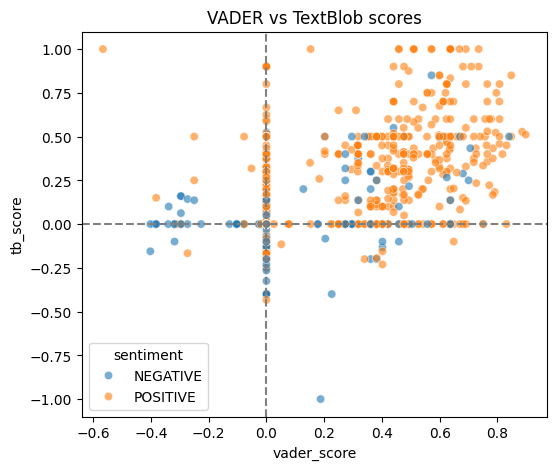

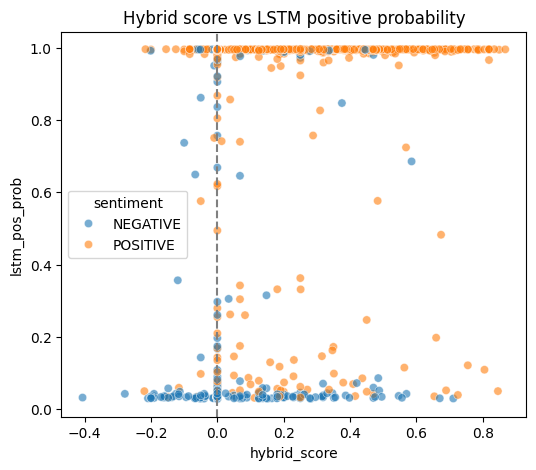

In [19]:
plt.figure(figsize=(6,5))
sns.scatterplot(
    x="vader_score", y="tb_score",
    hue="sentiment", data=df, alpha=0.6
)
plt.axvline(0, color="gray", linestyle="--")
plt.axhline(0, color="gray", linestyle="--")
plt.title("VADER vs TextBlob scores")
plt.show()

plt.figure(figsize=(6,5))
sns.scatterplot(
    x="hybrid_score", y="lstm_pos_prob",
    hue="sentiment", data=df, alpha=0.6
)
plt.axvline(0, color="gray", linestyle="--")
plt.title("Hybrid score vs LSTM positive probability")
plt.show()

In [20]:
# Numeric overview: count, mean, std, min, 25%, 50% (median), 75%, max
df.describe()

,start,duration,end,word_count,sentiment_num,time_bin,vader_score,tb_score,hybrid_score,lstm_pos_prob,sentiment_num_mapped
count,1067.000000,1067.000000,1067.000000,1067.000000,1067.000000,1067.00000,1067.000000,1067.000000,1067.000000,1067.000000,1067.000000
mean,2146.794877,3.451342,2150.246219,6.938144,0.445173,2086.33552,0.192008,0.177048,0.184528,0.703998,0.445173
std,1238.183406,1.152436,1238.163345,3.188558,0.895864,1238.16740,0.272476,0.266707,0.232077,0.427938,0.895864
min,0.163000,1.001000,3.934000,0.000000,-1.000000,0.00000,-0.566100,-1.000000,-0.406150,0.028041,-1.000000
25%,1069.815500,2.602500,1072.568000,5.000000,-1.000000,960.00000,0.000000,0.000000,0.000000,0.071524,-1.000000
50%,2133.762000,3.403000,2136.631000,7.000000,1.000000,2040.00000,0.000000,0.000000,0.125000,0.993529,1.000000
75%,3200.560500,4.238000,3203.847000,9.000000,1.000000,3120.00000,0.421500,0.376894,0.336500,0.995141,1.000000
max,4296.189000,7.675000,4301.060000,16.000000,1.000000,4200.00000,0.897900,1.000000,0.867550,0.995871,1.000000


In [21]:
# Sentiment distribution (mode for labels)
df["sentiment"].value_counts(dropna=False)

,count
sentiment,
POSITIVE,771
NEGATIVE,296


In [22]:
# If you have sentiment_num (e.g., -1, 0, 1)
df["sentiment_num"].describe()

,sentiment_num
count,1067.000000
mean,0.445173
std,0.895864
min,-1.000000
25%,-1.000000
50%,1.000000
75%,1.000000
max,1.000000


Sentiment class plots

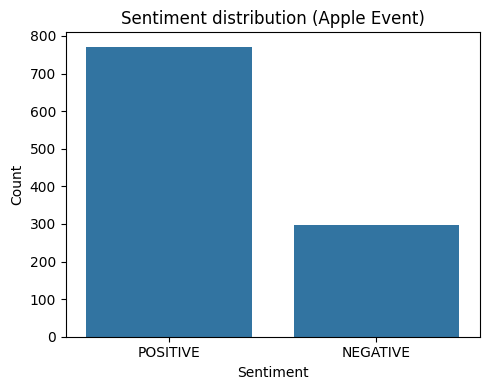

In [23]:
plt.figure(figsize=(5,4))
sns.countplot(x="sentiment", data=df, order=df["sentiment"].value_counts().index)
plt.title("Sentiment distribution (Apple Event)")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

Score distributions

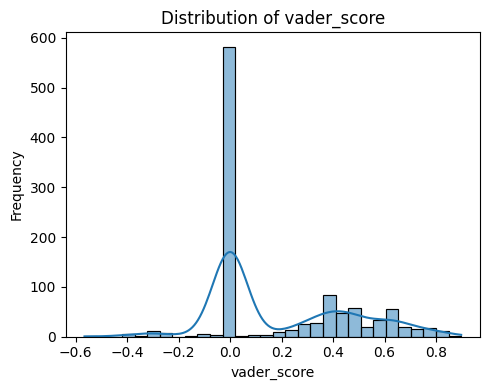

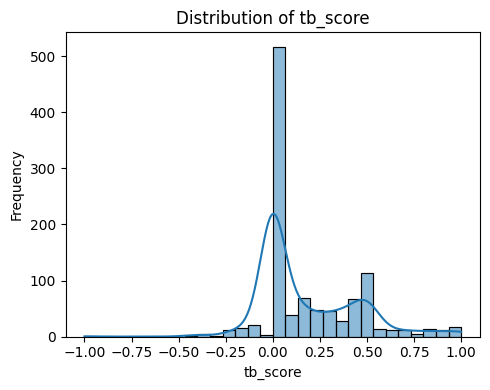

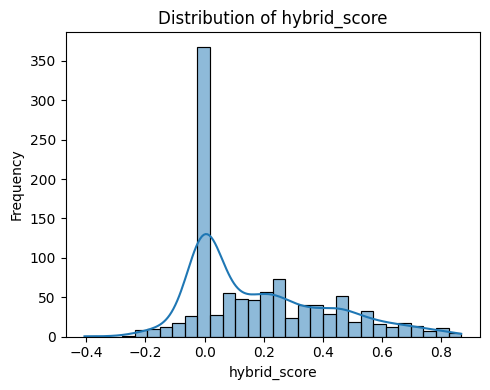

In [24]:
score_cols = ["vader_score", "tb_score", "hybrid_score"]
for col in score_cols:
    if col in df.columns:
        plt.figure(figsize=(5,4))
        sns.histplot(df[col], kde=True, bins=30)
        plt.title(f"Distribution of {col}")
        plt.xlabel(col)
        plt.ylabel("Frequency")
        plt.tight_layout()
        plt.show()

Classification reports and accuracy

In [25]:
from sklearn.metrics import classification_report, accuracy_score

# Logistic Regression
y_pred_logreg = logreg.predict(X_test_tfidf)
print("Logistic Regression accuracy:", accuracy_score(y_test, y_pred_logreg))
print(classification_report(y_test, y_pred_logreg))

# Linear SVM
y_pred_svm = svm.predict(X_test_tfidf)
print("Linear SVM accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))

Logistic Regression accuracy: 0.7242990654205608
              precision    recall  f1-score   support

    NEGATIVE       0.50      0.03      0.06        59
    POSITIVE       0.73      0.99      0.84       155

    accuracy                           0.72       214
   macro avg       0.61      0.51      0.45       214
weighted avg       0.67      0.72      0.62       214

Linear SVM accuracy: 0.7476635514018691
              precision    recall  f1-score   support

    NEGATIVE       0.61      0.24      0.34        59
    POSITIVE       0.76      0.94      0.84       155

    accuracy                           0.75       214
   macro avg       0.69      0.59      0.59       214
weighted avg       0.72      0.75      0.71       214



In [26]:
# LSTM
loss, acc = lstm_model.evaluate(X_test_pad, y_test_cat, verbose=0)
print("LSTM test accuracy:", acc)

y_proba_lstm = lstm_model.predict(X_test_pad)
y_pred_lstm_int = np.argmax(y_proba_lstm, axis=1)
y_pred_lstm = [idx_to_label[i] for i in y_pred_lstm_int]

print(classification_report([idx_to_label[i] for i in y_test_int], y_pred_lstm))

LSTM test accuracy: 0.7429906725883484
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
              precision    recall  f1-score   support

    NEGATIVE       0.53      0.68      0.59        59
    POSITIVE       0.86      0.77      0.81       155

    accuracy                           0.74       214
   macro avg       0.69      0.72      0.70       214
weighted avg       0.77      0.74      0.75       214



Model comparison table

In [27]:
metrics_rows = []

# LogReg
metrics_rows.append({
    "Model": "Logistic Regression",
    "Accuracy": accuracy_score(y_test, y_pred_logreg)
})

# SVM
metrics_rows.append({
    "Model": "Linear SVM",
    "Accuracy": accuracy_score(y_test, y_pred_svm)
})

# LSTM
metrics_rows.append({
    "Model": "LSTM",
    "Accuracy": acc
})

model_results = pd.DataFrame(metrics_rows)
model_results

,Model,Accuracy
0,Logistic Regression,0.724299
1,Linear SVM,0.747664
2,LSTM,0.742991


In [28]:
# Attach predictions for all rows
X_all_tfidf = tfidf.transform(df["title"].values)
df["logreg_pred"] = logreg.predict(X_all_tfidf)
df["svm_pred"] = svm.predict(X_all_tfidf)

all_seq = tokenizer.texts_to_sequences(df["title"].values)
all_pad = pad_sequences(all_seq, maxlen=max_len, padding="post", truncating="post")
all_proba = lstm_model.predict(all_pad)
all_pred_int = np.argmax(all_proba, axis=1)
df["lstm_pred"] = [idx_to_label[i] for i in all_pred_int]

if "POSITIVE" in label_to_idx:
    df["lstm_pos_prob"] = all_proba[:, label_to_idx["POSITIVE"]]
else:
    df["lstm_pos_prob"] = all_proba.max(axis=1)

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [29]:
# Most positive / most negative segments by LSTM probability
most_pos = df.sort_values("lstm_pos_prob", ascending=False).head(10)
most_neg = df.sort_values("lstm_pos_prob", ascending=True).head(10)

print("Most positive segments:")
display(most_pos[["text", "clean_text", "sentiment", "logreg_pred", "svm_pred", "lstm_pred", "lstm_pos_prob"]])

print("Most negative segments:")
display(most_neg[["text", "clean_text", "sentiment", "logreg_pred", "svm_pred", "lstm_pred", "lstm_pos_prob"]])

Most positive segments:


,text,clean_text,sentiment,logreg_pred,svm_pred,lstm_pred,lstm_pos_prob
1056,will enrich people’s\nlives in so many ways.,will enrich people’s\nlives in so many ways.,POSITIVE,POSITIVE,POSITIVE,POSITIVE,0.995871
516,also power Apple Intelligence.,also power apple intelligence.,POSITIVE,POSITIVE,POSITIVE,POSITIVE,0.995836
968,"Amazing Pro features\nlike Dolby Vision HDR,","amazing pro features\nlike dolby vision hdr,",POSITIVE,POSITIVE,POSITIVE,POSITIVE,0.995835
450,and they will be available\nstarting September...,and they will be available\nstarting september...,POSITIVE,POSITIVE,POSITIVE,POSITIVE,0.995828
640,with our most advanced features.,with our most advanced features.,POSITIVE,POSITIVE,POSITIVE,POSITIVE,0.995821
130,These updates are so important for our\nusers ...,these updates are so important for our\nusers ...,POSITIVE,POSITIVE,POSITIVE,POSITIVE,0.995816
731,enables the latest signature features\nof the ...,enables the latest signature features\nof the ...,POSITIVE,POSITIVE,POSITIVE,POSITIVE,0.995804
182,"an exceptional fit,\nand innovative fitness ca...","an exceptional fit,\nand innovative fitness ca...",POSITIVE,POSITIVE,POSITIVE,POSITIVE,0.995800
43,AirPods deliver a truly magical user\nexperien...,airpods deliver a truly magical user\nexperien...,POSITIVE,POSITIVE,POSITIVE,POSITIVE,0.995797
40,AirPods are the best and most\npopular headpho...,airpods are the best and most\npopular headpho...,POSITIVE,POSITIVE,POSITIVE,POSITIVE,0.995795


Most negative segments:


,text,clean_text,sentiment,logreg_pred,svm_pred,lstm_pred,lstm_pos_prob
789,That's enough to binge on all\n40 episodes of ...,that's enough to binge on all\n40 episodes of ...,NEGATIVE,POSITIVE,NEGATIVE,NEGATIVE,0.028041
0,♪ “Neon: 1. Shinjuku” by Hannah Peel \n& Manch...,♪ “neon: 1. shinjuku” by hannah peel \n& manch...,NEGATIVE,NEGATIVE,NEGATIVE,NEGATIVE,0.028727
18,♪ “Neon: 1. Shinjuku” by Hannah Peel \n& Manch...,♪ “neon: 1. shinjuku” by hannah peel \n& manch...,NEGATIVE,NEGATIVE,NEGATIVE,NEGATIVE,0.028727
233,I don't think I was ready\nto finish my life t...,i don't think i was ready\nto finish my life t...,NEGATIVE,POSITIVE,NEGATIVE,NEGATIVE,0.028854
788,"When using them together, iPhone Air\nhas up t...","when using them together, iphone air\nhas up t...",NEGATIVE,NEGATIVE,NEGATIVE,NEGATIVE,0.029064
229,I started feeling dizzy\nand that's the last t...,i started feeling dizzy\nand that's the last t...,NEGATIVE,NEGATIVE,NEGATIVE,NEGATIVE,0.029093
242,"That's why I started,\nto help my mental health.","that's why i started,\nto help my mental health.",NEGATIVE,POSITIVE,NEGATIVE,NEGATIVE,0.029116
989,Whether using multiple cameras\nor onscreen gr...,whether using multiple cameras\nor onscreen gr...,NEGATIVE,POSITIVE,NEGATIVE,NEGATIVE,0.029183
700,"Wi-Fi 7, Bluetooth 6, and Thread,","wi-fi 7, bluetooth 6, and thread,",NEGATIVE,POSITIVE,NEGATIVE,NEGATIVE,0.029191
231,"No food, no water.","no food, no water.",NEGATIVE,POSITIVE,NEGATIVE,NEGATIVE,0.029347


Sentiment over time

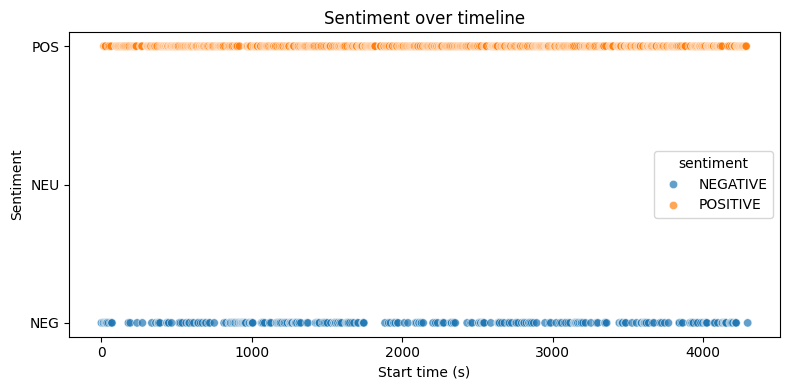

In [30]:
plt.figure(figsize=(8,4))
sns.scatterplot(x="start", y="sentiment_num", hue="sentiment", data=df, alpha=0.7)
plt.yticks([-1, 0, 1], ["NEG", "NEU", "POS"])
plt.title("Sentiment over timeline")
plt.xlabel("Start time (s)")
plt.ylabel("Sentiment")
plt.tight_layout()
plt.show()

Duration by sentiment (boxplot + violin)

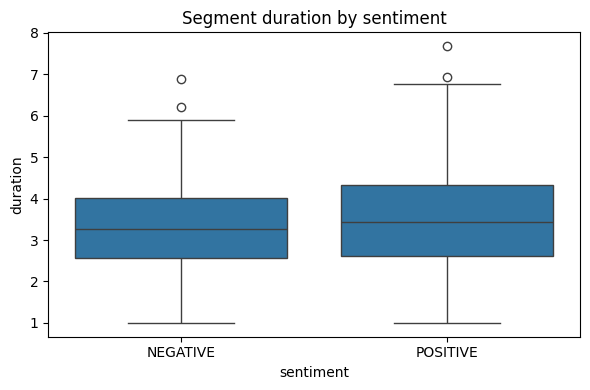

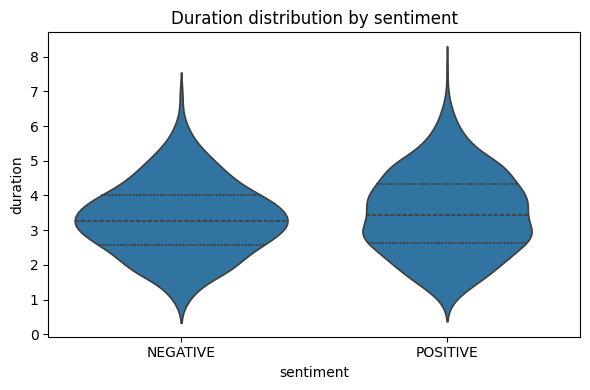

In [31]:
plt.figure(figsize=(6,4))
sns.boxplot(x="sentiment", y="duration", data=df)
plt.title("Segment duration by sentiment")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
sns.violinplot(x="sentiment", y="duration", data=df, inner="quartile")
plt.title("Duration distribution by sentiment")
plt.tight_layout()
plt.show()

Word count vs. sentiment

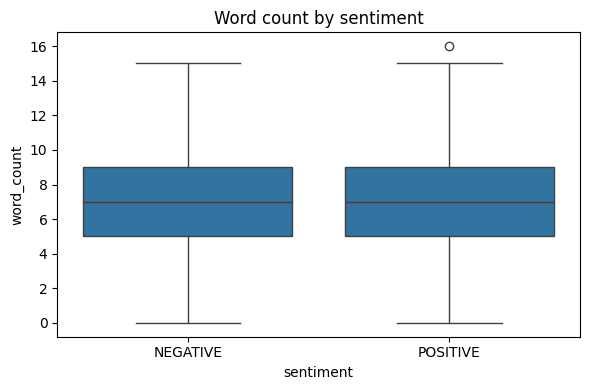

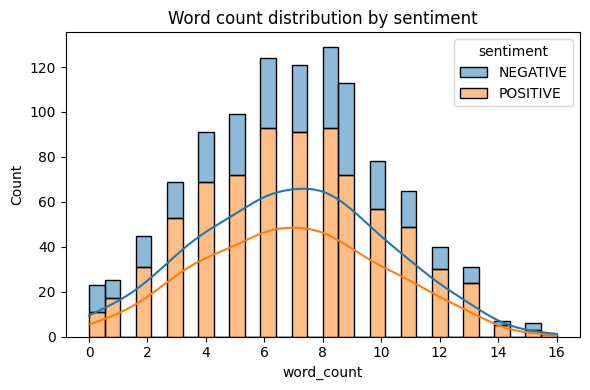

In [32]:
plt.figure(figsize=(6,4))
sns.boxplot(x="sentiment", y="word_count", data=df)
plt.title("Word count by sentiment")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
sns.histplot(data=df, x="word_count", hue="sentiment", bins=30, kde=True, multiple="stack")
plt.title("Word count distribution by sentiment")
plt.tight_layout()
plt.show()

Sentiment by time bin

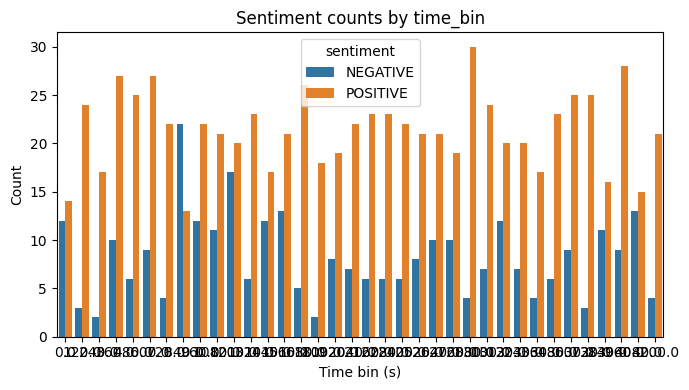

In [33]:
plt.figure(figsize=(7,4))
sns.countplot(x="time_bin", hue="sentiment", data=df)
plt.title("Sentiment counts by time_bin")
plt.xlabel("Time bin (s)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

Model confidence plots (LSTM)

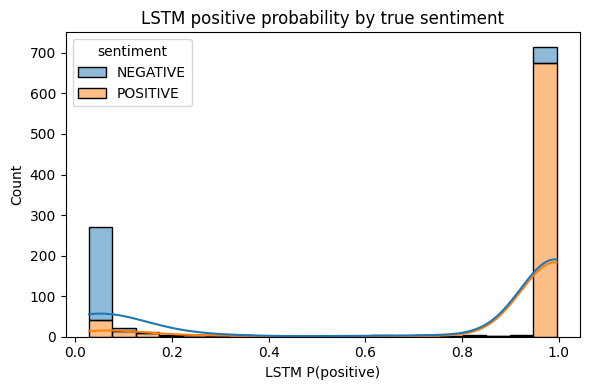

In [34]:
plt.figure(figsize=(6,4))
sns.histplot(data=df, x="lstm_pos_prob", hue="sentiment", bins=20, kde=True, multiple="stack")
plt.title("LSTM positive probability by true sentiment")
plt.xlabel("LSTM P(positive)")
plt.tight_layout()
plt.show()

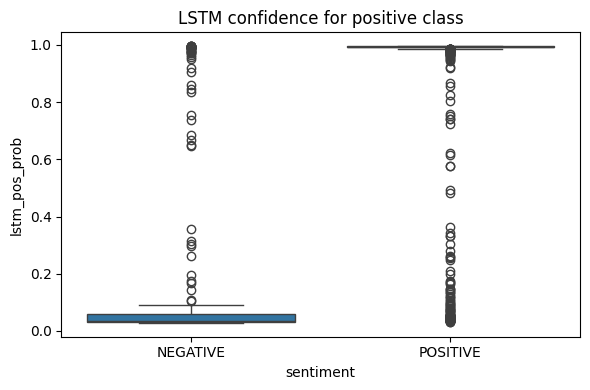

In [35]:
plt.figure(figsize=(6,4))
sns.boxplot(x="sentiment", y="lstm_pos_prob", data=df)
plt.title("LSTM confidence for positive class")
plt.tight_layout()
plt.show()